# Bayesian Stochastic Gradient Langevin Dynamic

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import approx_fprime  # Numerical derivative
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.sgld import sgld

In [2]:
sns.set(style="whitegrid")
dpi=200

## Synthetic Data

In [3]:
# Data Generating Model
def data_generating_model(n, w_true):
    z = np.empty(n)
    p1 = 0.5
    p2 = 1.0 - p1
    phi = 20
    sig2 = 5
    lab = np.random.uniform(0, 1, n) > p1
    z[lab] = lab[lab] * np.random.normal(w_true, np.sqrt(sig2), sum(lab)) + \
             (1 - lab[lab]) * np.random.normal(phi - w_true, np.sqrt(sig2), sum(lab))
    z[~lab] = np.random.normal(w_true, np.sqrt(sig2), sum(~lab))
    return z

In [4]:
np.random.seed(43)
n = 1_000_000
w_true = 5
z_obs = data_generating_model(n, w_true)

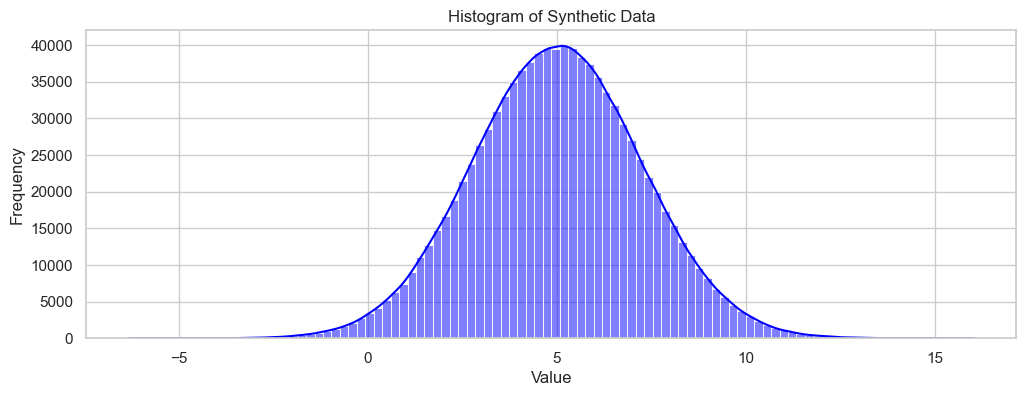

In [5]:
plt.figure(figsize=(12, 4))
sns.histplot(z_obs, bins=100, kde=True, color='blue')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Synthetic Data")
plt.show()

## Setup Functions

In [6]:
def log_sampling_pdf(w, z, p1=0.5, phi=20, sig2=5):
    return np.log(p1 * stats.norm.pdf(z, loc=w, scale=np.sqrt(sig2)) + \
                  (1 - p1) * stats.norm.pdf(z, loc=phi - w, scale=np.sqrt(sig2)))

def log_prior_pdf(w, mu=0.0, sig2=100):
    return np.log(stats.norm.pdf(w, loc=mu, scale=np.sqrt(sig2)))

In [7]:
def grad_log_sampling_pdf(w, z):
    def aux_fun(w_):
        return log_sampling_pdf(w_, z)
    return approx_fprime(w, aux_fun, epsilon=1e-5)

def grad_log_prior_pdf(w):
    return approx_fprime(w, log_prior_pdf, epsilon=1e-5)

## SGLD Algorithm

First we define the `learning_rate` function.

In [8]:
def learning_rate(epoch, max_epochs):
    if epoch <= 0.3*max_epochs:
        eta = 0.001
    elif epoch <= 0.6*max_epochs:
        eta = 0.001 / ((epoch - 0.3*max_epochs)**0.6)
    else:
        eta = 0.001 / ((0.3*max_epochs)**0.5)
    return eta

In [9]:
w_opt, w_trace = sgld(grad_log_sampling_pdf, grad_log_prior_pdf, z_obs, [3], learning_rate, batch_size=500,
                      tau=5.0, max_epochs=5000, return_trace=True)

print(f"Optimum Weight: {w_opt[0]}")

Optimum Weight: 4.970019499275827


### Trace Plot

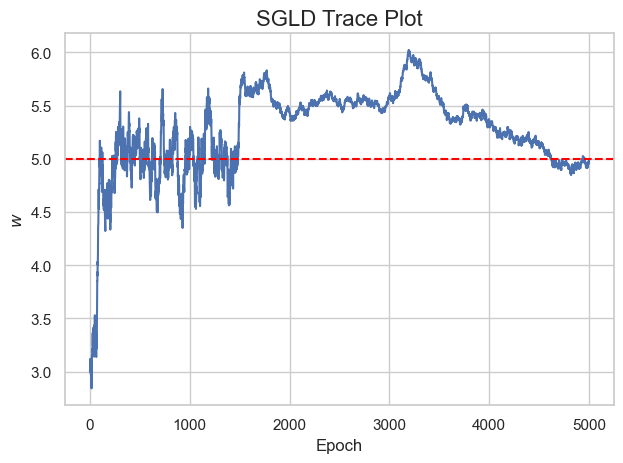

In [11]:
w_trace_list = [float(x) for x in w_trace]

sns.lineplot(x=range(len(w_trace_list)), y=w_trace_list)
plt.ylabel('$w$')
plt.xlabel('Epoch')
plt.title('SGLD Trace Plot', fontsize=16)
plt.axhline(y=w_true, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('images/sgld_trace_plot', dpi=dpi)
plt.show()